In [1]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd
import eipy.ei as e

In [2]:
from eipy.metrics import fmax_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef

metrics = {
            'f_max': fmax_score,
            'auc': roc_auc_score,
            'mcc': matthews_corrcoef
            }

In [3]:
base_predictors = {
                    'ADAB': AdaBoostClassifier(),
                    'XGB': XGBClassifier(),
                    'DT': DecisionTreeClassifier(),
                    'RF': RandomForestClassifier(),
                    'GB': GradientBoostingClassifier(),
                    'KNN': KNeighborsClassifier(),
                    'LR': LogisticRegression(),
                    'NB': GaussianNB(),
                    'MLP': MLPClassifier(),
                    'SVM': SVC(probability=True),
}

In [4]:
import pickle as pkl
with open("/home/opc/eipy/tadpole/tadpole_data_time_imptn_norm_v1.pickle", "rb") as file:
    data = pkl.load(file)
with open("/home/opc/eipy/tadpole/tadpole_labels_time_imptn_norm_v1.pickle", "rb") as file:
    labels = pkl.load(file)

In [5]:
data = [data[k] for k in data.keys()]

In [6]:
for k,v in labels.items():
    labels[k] = v.reset_index(drop=True)

In [7]:
#intermediate transformation to make sure labels are ordered correctly in time
labels = pd.DataFrame(labels)

labels = labels.to_numpy()

In [8]:
import numpy as np
encoding_dict = {'NL': 0, 'MCI': 1, 'Dementia': 2}

# Use numpy.vectorize with a lambda function to apply the encoding
labels = np.vectorize(lambda x: encoding_dict[x])(labels)

In [9]:
'''data misalignment'''
data=data[:-1]
labels = labels[:,1:]

In [10]:
for i in range(labels.shape[-1]):
    print(pd.Series(labels[:,i]).value_counts())

1    480
0    195
2     27
Name: count, dtype: int64
1    451
0    192
2     59
Name: count, dtype: int64
1    378
0    188
2    136
Name: count, dtype: int64
1    348
2    178
0    176
Name: count, dtype: int64


In [11]:
'''x patients have dementia 0 times in their label sequence,
 y patients have dementia once in their label sequence...'''
dem_freq = np.sum(labels == 2, axis=1)
pd.Series(dem_freq).value_counts()

0    378
1    250
2     72
3      2
Name: count, dtype: int64

In [12]:
'''how many patients get dementia at some point'''
np.any(labels == 2, axis=1).sum()

324

In [13]:
'''data split to validate hyper-parameter tuning'''
data_train = []
data_test = []
labels_train = []
labels_test = []

from sklearn.model_selection import train_test_split
for i in range(len(data)):
    print("hi")


hi
hi
hi
hi


In [14]:
####HI OVER HERE###
import importlib
importlib.reload(e)
###HEYOOOOOO#

<module 'eipy.ei' from '/home/opc/eipy/eipy/ei.py'>

In [15]:
outer_folds = 5

In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

meta_data = []
for t in range(len(data)):
    #time dependent data splitting
    X_train_timestep = data[t]
    labels_at_timestep = labels[:, t]
    EI_for_timestep = e.EnsembleIntegration(
                        base_predictors=base_predictors,
                        k_outer=outer_folds,
                        k_inner=5,
                        n_samples=1,
                        sampling_strategy="oversampling",
                        sampling_aggregation="mean",
                        n_jobs=-1,
                        metrics=metrics,
                        random_state=38,
                        project_name=f"time step {t}",
                        verbose=0,
                        model_building=False,
                        )
    print(f"generating metadata for timestep {t}")
    EI_for_timestep.final_label_frequency = dem_freq
    EI_for_timestep.fit_base(X_train_timestep, labels_at_timestep)
    meta_data.append([EI_for_timestep.ensemble_training_data, EI_for_timestep.ensemble_test_data, EI_for_timestep.ensemble_training_data_final, EI_for_timestep.base_summary])

warnings.filterwarnings("default", category=UserWarning)

generating metadata for timestep 0
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




generating metadata for timestep 1
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




generating metadata for timestep 2
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




generating metadata for timestep 3
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


In [17]:
RNN_training_data = [[dfs[0][i] for dfs in meta_data] for i in range(outer_folds)]
RNN_test_data = [[dfs[1][i] for dfs in meta_data] for i in range(outer_folds)]
RNN_training_data_final = [df[2] for df in meta_data]

### make first time point in meta-data multiclass

In [18]:
# def get_column_names(frame):
#     column_names = []
#     for i in range(frame.columns.nlevels):
#         if i == 0:
#             column_names.append(frame.columns.get_level_values(i).unique().drop("labels"))
            
#         else:
#             column_names.append(frame.columns.get_level_values(i).unique().drop(''))
    
#     return column_names

In [19]:
# def fix_first_time_point(df):
#     new_columns = get_column_names(df)
#     classes=[0,1,2]
#     new_columns.append(classes)
#     new_mux=pd.MultiIndex.from_product(iterables=new_columns, names=["modality", "base predictor", "sample", "class"])
#     new_df = pd.DataFrame(columns=new_mux)

#     for col in new_df.columns:
#         if col[-1] == 0:
#             new_df[col] = 1 - df[col[:-1]]
#         elif col[-1] == 1:
#             new_df[col] = df[col[:-1]]
#         else:
#             new_df[col] = 0
    
#     new_df['labels'] = df['labels']

#     return new_df

In [20]:
# for i in range(len(RNN_training_data)):
#     RNN_training_data[i][0] = fix_first_time_point(RNN_training_data[i][0])
#     RNN_test_data[i][0] = fix_first_time_point(RNN_test_data[i][0])

ValueError: Length of names must match number of levels in MultiIndex.

# TIME SERIES TIME

In [31]:
'''Alternate loss function that is label appropriate'''

from keras import backend as K

def ordinal_regression_loss(y_true, y_pred):
    """
    Ordinal regression loss function.

    Parameters:
    - y_true: true labels (ground truth)
    - y_pred: predicted labels

    Returns:
    - loss value
    """
    # Assuming y_true and y_pred are tensors of shape (batch_size, num_classes)

    # Calculate cumulative probabilities for true and predicted labels
    true_cum_probs = K.cumsum(K.softmax(y_true, axis=-1), axis=-1)
    pred_cum_probs = K.cumsum(K.softmax(y_pred, axis=-1), axis=-1)

    # Calculate the ordinal regression loss
    loss = K.sum((true_cum_probs - pred_cum_probs) ** 2)

    return loss

2024-01-16 16:26:04.641118: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 16:26:04.667226: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 16:26:04.667253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 16:26:04.668050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 16:26:04.672562: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 16:26:04.673084: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [118]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
import tensorflow as tf
y_preds = [] # LSTM predictions at every time point. Will be populated by 5 arrays
for i in range(len(RNN_training_data)):
    tf.random.set_seed(38)
    lstm = Sequential()
    lstm.add(LSTM(units=100+20*(i+1), input_shape=(len(data),240), return_sequences=True)) #units=80+10*(i+1)
    lstm.add(Dense(units=3, activation='softmax'))
    lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #loss='categorical_crossentropy'


    labels_across_time = np.column_stack([df['labels'].values for df in RNN_training_data[i]])
    labels_across_time = np.eye(3)[labels_across_time]


    RNN_training_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_training_data[i]]
    data_arrays_per_timepoint = [df.to_numpy() for df in RNN_training_data_fold]
    tensor_3d = np.stack(data_arrays_per_timepoint, axis=0)
    tensor_3d = np.transpose(tensor_3d, (1,0,2))

    lstm.fit(tensor_3d, labels_across_time, epochs=100)

    RNN_test_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_test_data[i]]
    data_arrays_per_timepoint_test = [df.to_numpy() for df in RNN_test_data_fold]
    tensor_3d_test = np.stack(data_arrays_per_timepoint_test, axis=0)
    tensor_3d_test = np.transpose(tensor_3d_test, (1,0,2))

    y_preds.append(lstm.predict(tensor_3d_test))

Epoch 1/100


/tmp/ipykernel_3047662/4047874034.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  RNN_training_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_training_data[i]]


18/18 [==============================] - 1s 4ms/step - loss: 0.9666 - accuracy: 0.5851
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8850 - accuracy: 0.6038
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8610 - accuracy: 0.6105
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8675 - accuracy: 0.6020
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8452 - accuracy: 0.6136
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8363 - accuracy: 0.6212
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8289 - accuracy: 0.6239
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8183 - accuracy: 0.6283
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8074 - accuracy: 0.6341
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7993 - accuracy: 0.6417
Epoch 11/100
18/18 [=

/tmp/ipykernel_3047662/4047874034.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  RNN_test_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_test_data[i]]


5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/18 [==============================] - 1s 4ms/step - loss: 0.9798 - accuracy: 0.5735
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8895 - accuracy: 0.5945
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8677 - accuracy: 0.5989
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8682 - accuracy: 0.5998
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8494 - accuracy: 0.6083
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8472 - accuracy: 0.6065
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8364 - accuracy: 0.6105
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8311 - accuracy: 0.6119
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8232 - accuracy: 0.6194
Epoch 10/100
18/18 [==============================] - 0s 4

In [119]:
y_preds_argmax = [np.argmax(pred, axis=-1) for pred in y_preds]

In [120]:
y_trues = []
for i in range(len(RNN_test_data)):
    y_true = pd.concat([data["labels"] for data in RNN_test_data[i]], axis=1).to_numpy()
    y_trues.append(y_true)


In [121]:
from sklearn.metrics import f1_score
f1s=[]
for i in range(len(y_preds_argmax)):
    f1s_for_fold=[]
    for j in range(y_preds_argmax[i].shape[-1]):
        f1s_for_fold.append(f1_score(y_preds_argmax[i][:,j], y_trues[i][:,j], average='micro'))
    f1s.append(f1s_for_fold)

f1_df = pd.DataFrame(data=f1s, columns=["bl", "m06", "m12", "m24"])
f1_df


,bl,m06,m12,m24
0,0.631206,0.588652,0.425532,0.432624
1,0.680851,0.602837,0.574468,0.390071
2,0.571429,0.485714,0.471429,0.435714
3,0.592857,0.614286,0.485714,0.457143
4,0.528571,0.571429,0.442857,0.485714


In [122]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

confusion_matrices = [ [confusion_matrix(y_pred=y_preds_argmax[i][:,j], y_true=y_trues[i][:,j]) for j in range(len(data))] for i in range(len(y_trues))]

In [123]:
final_f1_dem = []
for i in range(len(y_preds_argmax)):
    print(f" \n FOLD {i+1} \n")
    for j in range(len(data)):
        print(classification_report(y_pred=y_preds_argmax[i][:,j], y_true=y_trues[i][:,j]))

 
 FOLD 1 

              precision    recall  f1-score   support

           0       0.40      0.42      0.41        38
           1       0.72      0.75      0.74        97
           2       0.00      0.00      0.00         6

    accuracy                           0.63       141
   macro avg       0.37      0.39      0.38       141
weighted avg       0.61      0.63      0.62       141

              precision    recall  f1-score   support

           0       0.38      0.38      0.38        34
           1       0.72      0.72      0.72        96
           2       0.09      0.09      0.09        11

    accuracy                           0.59       141
   macro avg       0.40      0.40      0.40       141
weighted avg       0.59      0.59      0.59       141

              precision    recall  f1-score   support

           0       0.30      0.44      0.36        36
           1       0.61      0.49      0.55        79
           2       0.22      0.19      0.20        26

    accu

/home/opc/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opc/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opc/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opc/.venv/lib64/python3.9/site-packages/

In [124]:
from sklearn.metrics import precision_recall_fscore_support
dem_f1 = []
for i in range(len(y_preds_argmax)):
    precision, recall, f1, support = precision_recall_fscore_support(y_pred=y_preds_argmax[i][:,-1], y_true=y_trues[i][:,-1])
    dem_f1.append(f1[2])

np.mean(dem_f1), np.std(dem_f1)

(0.23449879516586686, 0.054411615812831604)

In [125]:
dem_f1

[0.27848101265822783,
 0.21951219512195125,
 0.16666666666666669,
 0.1935483870967742,
 0.31428571428571433]

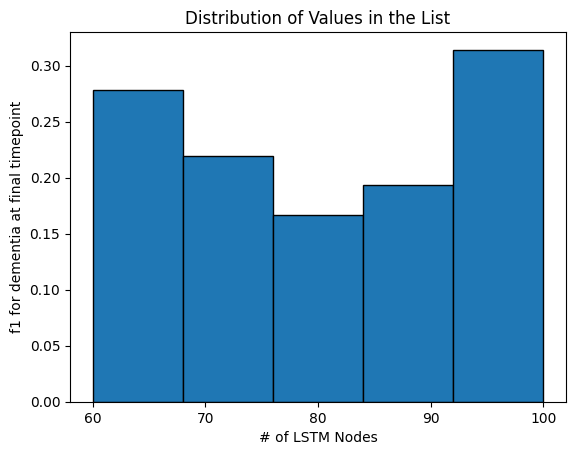

In [126]:
import matplotlib.pyplot as plt

plt.hist(range(1, len(dem_f1)+1), bins=len(dem_f1), weights=dem_f1, edgecolor='black', alpha=1)
plt.title('Distribution of Values in the List')
plt.xlabel('# of LSTM Nodes')
plt.ylabel('f1 for dementia at final timepoint')
plt.xticks(range(1, len(dem_f1) + 1), range(60, 60 + 10 * len(dem_f1), 10))
plt.show()